In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
SALE_PRICE = 'SalePrice'

# Очистка данных

## Разделим на котегориальные и колличественные признаки

In [3]:
def spread(data):
    categorical_columns = \
        [col for col in data.columns if data[col].dtype.name == 'object']

    numerical_columns = \
        [col for col in data.columns if (col != SALE_PRICE and data[col].dtype.name != 'object')]

    price_column = \
        [col for col in data.columns if col == SALE_PRICE]

    return categorical_columns, numerical_columns, price_column

## Заполнить пустые ячейки

In [4]:
def fillna(data, categorical_columns):

    # Заполним отсутсвующие значения колличественных признаков
    # медианными в текущем столбце
    data = data.fillna(data.median(axis=0), axis=0)
    # Заполнение отсутсвующих категориальных данных самыми популярными
    described_data = data.describe(include=[object])
    for col in categorical_columns:
        data[col] = data[col].fillna(described_data[col]['top'])

    return data, described_data

## Векторизовать данные

In [5]:
# Векторизация данных
def vectorize(data, described_data, categorical_cols, numerical_cols, price_column):
    # Признаки, принимающие бинарные значения
    binary_cols = \
        [col for col in categorical_cols if described_data[col]['unique'] == 2]
    # Признаки, принимающие небинарные значения
    nonbinary_cols = \
        [col for col in categorical_cols if described_data[col]['unique'] > 2]

    # Преобразуем данные бинарных признаков в 1 / 0
    for col in binary_cols:
        top = described_data[col]['top']
        top_items = data[col] == top
        data.loc[top_items, col] = 0
        data.loc[np.logical_not(top_items), col] = 1

    # Векторизация небинарных признаков
    data_nonbinary = pd.get_dummies(data[nonbinary_cols])

    # Нормализация количественных признаков
    data_numerical = data[numerical_cols]
    data_numerical = \
        (data_numerical - data_numerical.mean()) / data_numerical.std()
    data_price = data[price_column]

    # Слить в одну таблицу
    data = pd.concat((
        data_numerical,
        data[binary_cols],
        data_nonbinary,
        data_price
    ), axis=1)

    return pd.DataFrame(data, dtype=float)

## Подготовить данные (используя вышеописанные функции)

In [6]:
def prepare(data):
    categorical_cols, numerical_cols, price_column = spread(data)
    data, described_data = fillna(data, categorical_cols)
    data = vectorize(data, described_data, categorical_cols, numerical_cols, price_column)
    
    return data

# Загрузка тестового датасета

In [7]:
# ------------------------------------------------------------------------
# Загрузка данных
# ------------------------------------------------------------------------

train = pd.read_csv('./data/train.csv', index_col='Id', delimiter=',')
train = prepare(train)

train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,0.073350,-0.220799,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.513928,0.575228,-0.288554,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500.0
2,-0.872264,0.460162,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.570555,1.171591,-0.288554,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500.0
3,0.073350,-0.084607,0.073455,0.651256,-0.517023,0.984415,0.829930,0.325803,0.092875,-0.288554,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500.0
4,0.309753,-0.447787,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.570555,-0.499103,-0.288554,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,140000.0
5,0.073350,0.641752,0.375020,1.374324,-0.517023,0.951306,0.733056,1.366021,0.463410,-0.288554,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,250000.0
6,-0.163054,0.687149,0.360493,-0.794879,-0.517023,0.719540,0.490872,-0.570555,0.632233,-0.288554,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,143000.0
7,-0.872264,0.233175,-0.043364,1.374324,-0.517023,1.083743,0.975241,0.458597,2.028862,-0.288554,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,307000.0
8,0.073350,-0.039210,-0.013508,0.651256,0.381612,0.057352,-0.574741,0.757383,0.910682,-0.090190,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,200000.0
9,-0.163054,-0.856363,-0.440508,0.651256,-0.517023,-1.333243,-1.688790,-0.570555,-0.972685,-0.288554,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,129900.0


## Отбор информативных фич
Корреляция между фичами должна быть меньше, а между фичами и целевыми данными наоборот больше, чем 0,5

In [8]:
all_features = train.corr()[SALE_PRICE].abs()

actual_features = \
    [(f, all_features[f]) for f in train.columns if all_features[f] > 0.5]

actual_features = sorted(actual_features, key=lambda x: x[::-1], reverse=True)

# Отберем значимые фичи, т.к. знаем смысл каждой
MEANING_FEATURES = [
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'TotalBsmtSF',
    'ExterQual_TA',
    'FullBath',
    'BsmtQual_Ex',
    'TotRmsAbvGrd',
    'YearBuilt',
    'KitchenQual_TA',
    'GarageFinish_Unf',
    'KitchenQual_Ex'
]

train = train[MEANING_FEATURES + [SALE_PRICE]]

## Обработка и разделение данных

In [9]:
# Удаление выбросов
train = train[(np.abs(stats.zscore(train)) < 3).all(axis=1)]

# Разделение на обучающую и тестовую выборку
X = train.drop((SALE_PRICE), axis=1)
y = train[SALE_PRICE]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=11)


regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)
y_test_predict = regr.predict(X=X_test)

print('Coefficients: \n', regr.coef_)
print("MAE: %.2f" % mean_absolute_error(y_test, y_test_predict))
print('Variance score: %.2f' % r2_score(y_test, y_test_predict))

Coefficients: 
 [ 1.33474960e+04  3.55349106e+04  4.25369302e+03  1.24699864e+04
 -5.18723252e+03 -4.87989547e+03  5.91171556e-12 -7.23885844e+03
  1.01773839e+04 -1.27198131e+04 -5.67582165e+03  0.00000000e+00]
MAE: 18003.02
Variance score: 0.80


## Распределение стоимость / площадь

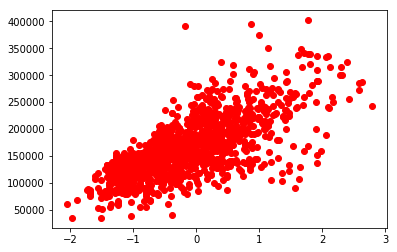

In [10]:
plt.plot(train['GrLivArea'], train['SalePrice'], 'ro')

## Проверка на тестовых данных

In [11]:
X_check = pd.read_csv('./data/test.csv', index_col='Id', delimiter=',')
y_check = pd.read_csv('./data/sample_submission.csv', index_col='Id', delimiter=',')

X_check = prepare(X_check)
X_check = X_check[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','ExterQual_TA','FullBath','BsmtQual_Ex','TotRmsAbvGrd','YearBuilt','KitchenQual_TA','GarageFinish_Unf','KitchenQual_Ex']]
y_check = y_check[['SalePrice']]

In [12]:
y_check_predict = regr.predict(X=X_check)
# y_check_predict

print('Coefficients: \n', regr.coef_)
print("MAE: %.2f" % mean_absolute_error(y_check, y_check_predict))
print('Variance score: %.2f' % r2_score(y_check, y_check_predict))

Coefficients: 
 [ 1.33474960e+04  3.55349106e+04  4.25369302e+03  1.24699864e+04
 -5.18723252e+03 -4.87989547e+03  5.91171556e-12 -7.23885844e+03
  1.01773839e+04 -1.27198131e+04 -5.67582165e+03  0.00000000e+00]
MAE: 47201.90
Variance score: -10.77
